Wednesday, June 21, 2023

My walkthrough of the notebook ...

[Chapter-2-Machine-Translation.ipynb](https://github.com/CRCTransformers/deepdive-book/blob/main/Chapter-2-Machine-Translation.ipynb)



### Machine Translation Comparison: Attention vs Transformer

In [1]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

Why do I always have so many issues with spacy??

!python -m spacy download fr  ... this NEVER works!

In [2]:
import spacy
import spacy.cli

In [3]:
spacyDownload = False
if spacyDownload:
    spacy.cli.download("en_core_web_sm")
    spacy.cli.download("fr_core_news_sm")

In [4]:
# !pip install ecco
# !pip install torchtext
# !pip install wget

# this would not work ... had to run outside of this container ...sigh
# %%capture
# !wget https://download.pytorch.org/tutorial/data.zip && unzip data.zip && rm data.zip

In [5]:
from io import open
import unicodedata
import string
import re
import random
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator
from collections import Counter 

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import ecco
     

In [6]:
torch.__version__

'2.0.1+cu118'

In [7]:
MAX_SENTENCE_LENGTH = 20
FILTER_TO_BASIC_PREFIXES = False
SAVE_DIR = os.path.join(".", "models")

ENCODER_EMBEDDING_DIM = 256
ENCODER_HIDDEN_SIZE = 256
DECODER_EMBEDDING_DIM = 256
DECODER_HIDDEN_SIZE = 256

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    !nvidia-smi
else:
    device = torch.device("cpu")
device

Tue Jun 27 15:50:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   59C    P0    N/A /  70W |    359MiB /  2048MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 24%   

device(type='cuda')

In [9]:
with open('data/eng-fra.txt', encoding="utf-8") as f:
    lines = f.read().strip().split("\n")

In [10]:
print(f"{len(lines):,} English-French phrase pairs.\n")
print("~~~~~ Examples: ~~~~~")
for example in random.choices(lines, k=5):
    pair = example.split('\t')
    print(f"English:  {pair[0]}")
    print(f"French:   {pair[1]}")
    print()

135,842 English-French phrase pairs.

~~~~~ Examples: ~~~~~
English:  She was absorbed in her work.
French:   Elle était absorbée par son travail.

English:  I just wanted to drop by to say hi.
French:   Je voulais juste passer pour vous saluer.

English:  I'd like some water.
French:   Je voudrais un peu d'eau.

English:  When I woke up this morning, I felt sick.
French:   Lorsque je me suis réveillée ce matin, je me sentais malade.

English:  Why are you so insecure?
French:   Pourquoi êtes-vous si anxieux ?



In [11]:
def unicodeToAscii(s):
    return ''.join(
      c for c in unicodedata.normalize('NFD', s) 
      if unicodedata.category(c) != 'Mn'
    )

In [12]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z.!?]+", " ", s)
    return s

In [13]:
def filterPair(p, max_length, prefixes):
    good_length = (len(p[0].split(' ')) < max_length) and (len(p[1].split(' ')) < max_length)
    if len(prefixes) == 0:
        return good_length
    else:
        return good_length and p[0].startswith(prefixes)

In [14]:
def filterPairs(pairs, max_length, prefixes=()):
    return [pair for pair in pairs if filterPair(pair, max_length, prefixes)]

In [15]:
def prepareData(lines, filter=False, reverse=False, max_length=10, prefixes=()):
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    print(f"Given {len(pairs):,} sentence pairs.")

    if filter:
        pairs = filterPairs(pairs, max_length=max_length, prefixes=prefixes)
        print(f"After filtering, {len(pairs):,} remain.")

    return pairs

In [16]:
basic_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ",
    'are you', 'am i ', 
    'were you', 'was i ', 
    'where are', 'where is',
    'what is', 'what are'
)

In [17]:
pairs = prepareData(lines, 
                    filter=True, 
                    max_length=MAX_SENTENCE_LENGTH, 
                    prefixes=basic_prefixes if FILTER_TO_BASIC_PREFIXES else ())

Given 135,842 sentence pairs.
After filtering, 135,284 remain.


The notebook from the authors repo shows 15, 593 remaining. Why do we get 135,284?

Let's try to explore this, shall we ... 

In [18]:
pairs2 = [[normalizeString(s) for s in l.split('\t')] for l in lines]

In [19]:
filteredPairs = filterPairs(pairs2, max_length=20, prefixes=basic_prefixes)
len(filteredPairs)

15593

In [20]:
filteredPairs = filterPairs(pairs2, max_length=20, prefixes=())
len(filteredPairs)

135284

In [21]:
pairs2[:10]

[['go.', 'va !'],
 ['run!', 'cours !'],
 ['run!', 'courez !'],
 ['wow!', 'ca alors !'],
 ['fire!', 'au feu !'],
 ['help!', 'a l aide !'],
 ['jump.', 'saute.'],
 ['stop!', 'ca suffit !'],
 ['stop!', 'stop !'],
 ['stop!', 'arrete toi !']]

### Prepare the data for modelling

In [22]:
# fr_tokenizer = get_tokenizer('spacy', language='fr')
# en_tokenizer = get_tokenizer('spacy', language='en')
fr_tokenizer = get_tokenizer('spacy', language='fr_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [23]:
SPECIALS = ['<unk>', '<pad>', '<bos>', '<eos>']

In [24]:
en_list = []
fr_list = []
en_counter = Counter()
fr_counter = Counter()
en_lengths = []
fr_lengths = []

In [25]:
for en, fr in pairs:
    en_toks = en_tokenizer(en)
    fr_toks = fr_tokenizer(fr)
    en_list += [en_toks]
    fr_list += [fr_toks]
    en_counter.update(en_toks)
    fr_counter.update(fr_toks)
    en_lengths.append(len(en_toks))
    fr_lengths.append(len(fr_toks))

In [26]:
en_list[:10]

[['go', '.'],
 ['run', '!'],
 ['run', '!'],
 ['wow', '!'],
 ['fire', '!'],
 ['help', '!'],
 ['jump', '.'],
 ['stop', '!'],
 ['stop', '!'],
 ['stop', '!']]

In [27]:
en_vocab = build_vocab_from_iterator(en_list, specials=SPECIALS)
fr_vocab = build_vocab_from_iterator(fr_list, specials=SPECIALS)

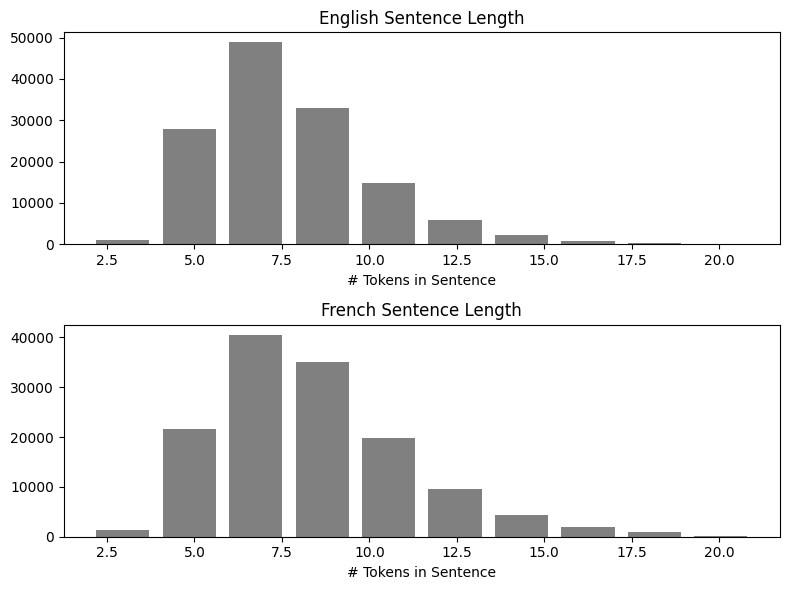

In [28]:
fig = plt.figure(figsize=(8, 6))
ax0 = fig.add_subplot(211)
ax0.hist(en_lengths, rwidth=0.8, color='gray')
ax0.set_title("English Sentence Length")
ax0.set_xlabel("# Tokens in Sentence")

ax1 = fig.add_subplot(212)
ax1.hist(fr_lengths, rwidth=0.8, color='gray')
ax1.set_title("French Sentence Length")
ax1.set_xlabel("# Tokens in Sentence")

plt.tight_layout()
plt.show()

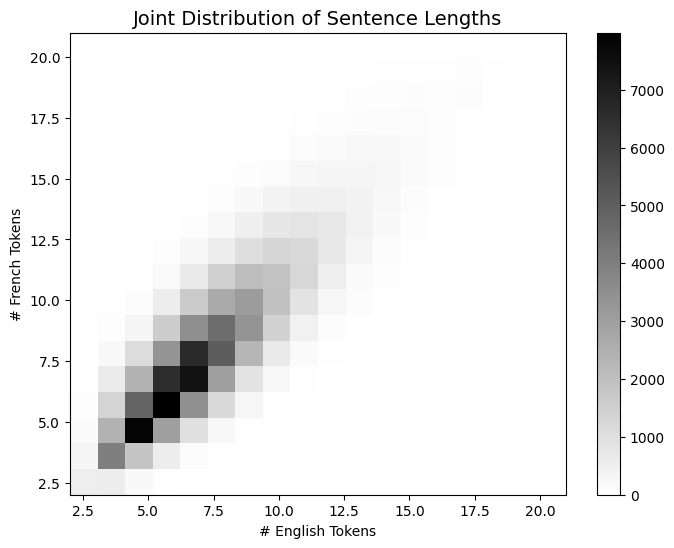

In [29]:

plt.figure(figsize=(8,6))
plt.hist2d(en_lengths, fr_lengths, bins=MAX_SENTENCE_LENGTH-2, cmap='binary')
plt.title("Joint Distribution of Sentence Lengths", fontsize=14)
plt.xlabel("# English Tokens")
plt.ylabel("# French Tokens")
plt.colorbar()
plt.show()

In [30]:
def plot_top_words(counter, k=20, ax=None):
    top_k = counter.most_common(k)
    words, freqs = zip(*reversed(top_k))

    if ax is None:
        plt.barh(words, freqs, color='gray')
    else:
        ax.barh(words, freqs, color='gray')


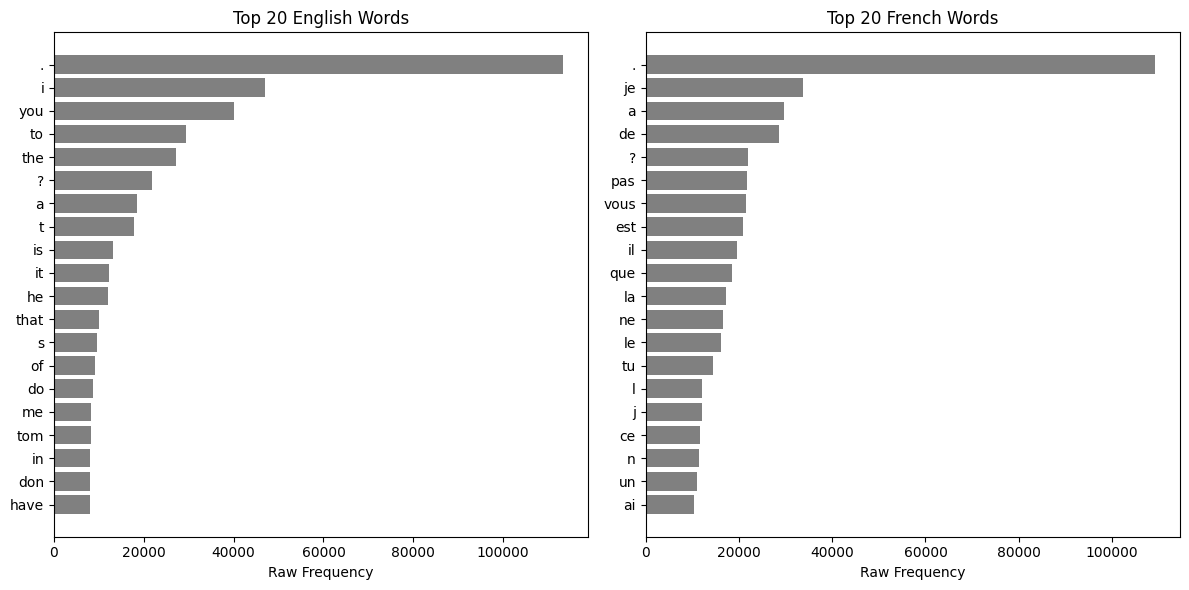

In [31]:

fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121)
plot_top_words(en_counter, ax=ax0)
ax0.set_title("Top 20 English Words")
ax0.set_xlabel("Raw Frequency")

ax1 = fig.add_subplot(122)
plot_top_words(fr_counter, ax=ax1)
ax1.set_title("Top 20 French Words")
ax1.set_xlabel("Raw Frequency")

plt.tight_layout()
plt.show()

In [32]:
VALID_PCT = 0.1
TEST_PCT = 0.1

train_data  = []
valid_data = []
test_data = []

random.seed(6547)

In [33]:
for (en, fr) in pairs:

    en_tensor = torch.tensor([en_vocab[token] for token in en_tokenizer(en)])
    fr_tensor = torch.tensor([fr_vocab[token] for token in fr_tokenizer(fr)])

    random_draw = random.random()

    if random_draw <= VALID_PCT:
        valid_data.append((en_tensor, fr_tensor))
    elif random_draw <= VALID_PCT + TEST_PCT:
        test_data.append((en_tensor, fr_tensor))
    else:
        train_data.append((en_tensor, fr_tensor))

In [34]:
print(f"""
  Training pairs: {len(train_data):,}
Validation pairs: {len(valid_data):,}
      Test pairs: {len(test_data):,}""")
     


  Training pairs: 108,111
Validation pairs: 13,648
      Test pairs: 13,525


In [35]:
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

In [36]:
for en_id, fr_id in zip(en_vocab.lookup_indices(SPECIALS), fr_vocab.lookup_indices(SPECIALS)):
    assert en_id == fr_id

In [37]:
def generate_batch(data_batch):
    '''
    Prepare English and French examples for batch-friendly modeling by appending
    BOS/EOS tokens to each, stacking the tensors, and filling trailing spaces of
    shorter sentences with the <pad> token. To be used as the collate_fn in the
    English-to-French DataLoader.

    Input: 
    - data_batch, an iterable of (English, French) tuples from the datasets 
    created above

    Outputs
    - en_batch: a (max length X batch size) tensor of English token IDs
    - fr_batch: a (max length X batch size) tensor of French token IDs 
    '''
    en_batch, fr_batch = [], []
    for (en_item, fr_item) in data_batch:
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
        fr_batch.append(torch.cat([torch.tensor([BOS_IDX]), fr_item, torch.tensor([EOS_IDX])], dim=0))

    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX, batch_first=False)
    fr_batch = pad_sequence(fr_batch, padding_value=PAD_IDX, batch_first=False)

    return en_batch, fr_batch

In [38]:
BATCH_SIZE = 16 # I know this works, but let's increase shall we ... 
BATCH_SIZE = 256 # Nice! This too also works ... keep going ...
BATCH_SIZE = 512
# BATCH_SIZE = 1024 # Nope! This Blows up!

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

In [39]:
for i, (en_id, fr_id) in enumerate(train_iter):
    print('English:', ' '.join([en_vocab.lookup_token(idx) for idx in en_id[:, 0]]))
    print('French:', ' '.join([fr_vocab.lookup_token(idx) for idx in fr_id[:, 0]]))
    if i == 4: 
        break
    else:
        print()

English: <bos> the doors were closed . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
French: <bos> les portes etaient closes . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

English: <bos> don t worry about what i did . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
French: <bos> ne te fais pas de souci au sujet de ce que j ai fait ! <eos> <pad> <pad> <pad>

English: <bos> do you know noah s ark ? <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
French: <bos> connais tu l arche de noe ? <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

English: <bos> i just don t want to believe it . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
French: <bos> je ne veux tout simplement pas y croire . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

English: <bos> how did you come up with that answer ? <eos> <pad> <pad> <pad> <pad> <pad> <

## LSTM with Attention

### Model Classes

In [40]:
class BahdanauEncoder(nn.Module):

    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout_p):

        super().__init__()
        self.intput_dim = input_dim
        self.embedding_dim = embedding_dim
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.linear = nn.Linear(encoder_hidden_dim *2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        '''
        Encode a source sentence. 

        Input:
          - x: a (sequence length, batch size) tensor of token IDs in source language

        Output:
          - outputs: encoder outputs at each time step, given as a tensor of size
            (sequence length, batch size, encoder hidden dim * 2)
          - hidden: final hidden state from RNN, with directions concatenated and
            fed through linear layer; tensor of size (batch size, decoder hidden dim)
        '''

        embedded = self.dropout(self.embedding(x))
        outputs, hidden = self.gru(embedded)

        hidden = torch.tanh(self.linear(torch.cat( ( hidden[-2, :, :], hidden[-1, :, :]) , dim=1 )))

        return outputs, hidden


In [41]:
class BahdanauAttentionQKV(nn.Module):

    def __init__(self, hidden_size, query_size=None, key_size = None, droput_p = 0.15):
        super().__init__()
        self.hidden_size = hidden_size
        self.query_size = hidden_size if query_size is None else query_size
        
        # assume a bidirectional encoder, but can specify otherwise
        self.key_size = 2 * hidden_size if key_size is None else key_size

        self.query_layer = nn.Linear(self.query_size, hidden_size)
        self.key_layer = nn.Linear(self.key_size, hidden_size)
        self.energy_layer = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(droput_p)

    def forward(self, hidden, encoder_outputs, src_mask=None):
        '''
        Calculate attention weights using query and key features, with
        an optional mask for input sequences.
        
        Inputs:
          - hidden: most recent RNN hidden state; (B, Dec)
          - encoder_outputs: RNN outputs at individual time steps with 
            directions concatenated; (L, B, 2*Enc)
          - src_mask: boolean tensor of same size as source tokens (Src, B) 
            where False denotes tokens to be ignored
            
        Outputs:
          - attention weights: (B, src) tensor of softmax attention 
            weights to be applied to downstream values
        '''

        # (B, H)
        query_out = self.query_layer(hidden)

        # (Src, B, 2*H) --> (Src, B, H)
        key_out = self.key_layer(encoder_outputs)

        # (B, H) + (Src, B, H) --> (Src, B)
        energy_input = torch.tanh(query_out + key_out)

        # (Src, B, H) --> (Src, B, 1) --> (Src, B)
        energies = self.energy_layer(energy_input).squeeze(2)

        # if a mask is provided, remove masked tokens from softmax calc
        if src_mask is not None:
            energies.data.masked_fill_(src_mask == 0, float("-inf"))

        # softmax over the length dimension
        weights =  F.softmax(energies, dim=0)

        # return as (B, Src) as expected by later multiplication
        return weights.transpose(0, 1)


In [42]:
class BahdanauDecoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, encoder_hidden_dim, 
                 decoder_hidden_dim, attention, dropout_p):
        super().__init__()

        self.embedding_dim = embedding_dim 
        self.output_dim = output_dim 
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.dropout_p = dropout_p 

        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.attention = attention # allowing for custom attention
        self.gru = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, 
                          decoder_hidden_dim)
        self.out = nn.Linear((encoder_hidden_dim * 2) + embedding_dim + decoder_hidden_dim,
                             output_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input, hidden, encoder_outputs, src_mask=None):
        '''
        Decode an encoder's output. 

        B: batch size
        S: source sentence length
        T: target sentence length
        O: output size (target vocab size)
        Enc: encoder hidden dim
        Dec: decoder hidden dim
        Emb: embedding dim

        Inputs:
          - input: a vector of length B giving the most recent decoded token
          - hidden: a (B, Dec) most recent RNN hidden state
          - encoder_outputs: (S, B, 2*Enc) sequence of outputs from encoder RNN

        Outputs:
          - output: logits for next token in the sequence (B, O)
          - hidden: a new (B, Dec) RNN hidden state
          - attentions: (B, S) attention weights for the current token over the source sentence
        '''

        # (B) --> (1, B)
        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        attentions = self.attention(hidden, encoder_outputs, src_mask)

        # (B, S) --> (B, 1, S)
        a = attentions.unsqueeze(1)

        # (S, B, 2*Enc) --> (B, S, 2*Enc)
        encoder_outputs = encoder_outputs.transpose(0, 1)

        # weighted encoder representation
        # (B, 1, S) @ (B, S, 2*Enc) = (B, 1, 2*Enc)
        weighted = torch.bmm(a, encoder_outputs)

        # (B, 1, 2*Enc) --> (1, B, 2*Enc)
        weighted = weighted.transpose(0, 1)

        # concat (1, B, Emb) and (1, B, 2*Enc)
        # results in (1, B, Emb + 2*Enc)
        rnn_input = torch.cat((embedded, weighted), dim=2)

        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()

        # get rid of empty leading dimensions
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        # concatenate the pieces above
        # (B, Dec), (B, 2*Enc), and (B, Emb)
        # result is (B, Dec + 2*Enc + Emb)
        linear_input = torch.cat((output, weighted, embedded), dim=1)

        # (B, Dec + 2*Enc + Emb) --> (B, O)
        output = self.out(linear_input)

        return output, hidden.squeeze(0), attentions

In [43]:
class BahdanauSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device
        self.tgt_vocab_size = decoder.output_dim

    def forward(self, src, tgt, src_mask=None, teacher_forcing_ratio=0.5, return_attentions=False):

        tgt_length, batch_size = tgt.shape

        # store decoder outputs
        outputs = torch.zeros(tgt_length, batch_size, self.tgt_vocab_size).to(self.device)
        # attentions = torch.zeros(tgt_length, batch_size, )

        encoder_outputs, hidden = self.encoder(src)
        hidden = hidden.squeeze(1) # B, 1, Enc --> B, Enc (if necessary)

        # start with <bos> as the decoder input
        decoder_input = tgt[0, :]
        attentions = []

        for t in range(1, tgt_length):
            decoder_output, hidden, attention = self.decoder(decoder_input, hidden, encoder_outputs, src_mask)
            outputs[t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            top_token = decoder_output.max(1)[1]
            decoder_input = (tgt[t] if teacher_force else top_token)
            attentions.append(attention.unsqueeze(-1))

        if return_attentions:
            return outputs, torch.cat(attentions, dim=-1)
        else:
            return outputs

### Train Bahdanau Seq2Seq Model

In [44]:
class MultipleOptimizer(object):
    
    def __init__(self, *op):
        self.optimizers = op
    
    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()


In [45]:
def train(model, iterator, optimizer, loss_fn, device, clip=None):
    model.train()
    if model.device != device:
        model = model.to(device)
        
    epoch_loss = 0
    with tqdm(total=len(iterator), leave=False) as t:
        for i, (src, tgt) in enumerate(iterator):
            src_mask = (src != PAD_IDX).to(device)
            src = src.to(device)
            tgt = tgt.to(device)
            
            optimizer.zero_grad()
            
            output = model(src, tgt, src_mask)
            
            loss = loss_fn(output[1:].view(-1, output.shape[2]),
                           tgt[1:].view(-1))
            
            loss.backward()
            
            if clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            optimizer.step()
            epoch_loss += loss.item()
            
            avg_loss = epoch_loss / (i+1)
            t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                          ppl='{:05.3f}'.format(np.exp(avg_loss)))
            t.update()
            
    return epoch_loss / len(iterator)



In [46]:
def evaluate(model, iterator, loss_fn, device):
    model.eval()
    if model.device != device:
        model = model.to(device)
        
    epoch_loss = 0
    with torch.no_grad():
        with tqdm(total=len(iterator), leave=False) as t:
            for i, (src, tgt) in enumerate(iterator):
                src_mask = (src != PAD_IDX).to(device)
                src = src.to(device)
                tgt = tgt.to(device)
                
                output = model(src, tgt, src_mask, teacher_forcing_ratio=0)
                loss = loss_fn(output[1:].view(-1, output.shape[2]),
                               tgt[1:].view(-1))
                
                epoch_loss += loss.item()
                
                avg_loss = epoch_loss / (i+1)
                t.set_postfix(loss='{:05.3f}'.format(avg_loss),
                              ppl='{:05.3f}'.format(np.exp(avg_loss)))
                t.update()
    
    return epoch_loss / len(iterator)

In [47]:
enc = BahdanauEncoder(input_dim=len(en_vocab),
                      embedding_dim=ENCODER_EMBEDDING_DIM, 
                      encoder_hidden_dim=ENCODER_HIDDEN_SIZE, 
                      decoder_hidden_dim=DECODER_HIDDEN_SIZE, 
                      dropout_p=0.15)

In [48]:
attn = BahdanauAttentionQKV(DECODER_HIDDEN_SIZE)

In [49]:
dec = BahdanauDecoder(output_dim=len(fr_vocab), 
                      embedding_dim=DECODER_EMBEDDING_DIM,
                      encoder_hidden_dim=ENCODER_HIDDEN_SIZE, 
                      decoder_hidden_dim=DECODER_HIDDEN_SIZE,
                      attention=attn,
                      dropout_p=0.15)

In [50]:
seq2seq = BahdanauSeq2Seq(enc, dec, device)

In [51]:
def count_params(model, return_int=False):
    params = sum([torch.prod(torch.tensor(x.shape)).item() for x in model.parameters() if x.requires_grad])
    if return_int:
        return params
    else:
        print("There are {:,} trainable parameters in this model.".format(params))

In [52]:
count_params(seq2seq)

There are 32,361,414 trainable parameters in this model.


In [53]:
enc_optim = torch.optim.AdamW(seq2seq.encoder.parameters(), lr=1e-4)
dec_optim = torch.optim.AdamW(seq2seq.decoder.parameters(), lr=1e-4)
optims = MultipleOptimizer(enc_optim, dec_optim)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [54]:
reTrain = False
loadPreTrainedModel = not reTrain

In [55]:
N_EPOCHS = 20
CLIP = 10 # clipping value, or None to prevent gradient clipping
EARLY_STOPPING_EPOCHS = 2

if not os.path.exists(SAVE_DIR):
    print(f"Creating directory {SAVE_DIR}")
    os.mkdir(SAVE_DIR)

modelFileName = 'bahdanau_en_fr_BS_' + str(BATCH_SIZE) + '.pt'  
model_path = os.path.join(SAVE_DIR, modelFileName)
bahdanau_metrics = {}
best_valid_loss = float("inf")
early_stopping_count = 0
if reTrain:

    for epoch in tqdm(range(N_EPOCHS), leave=False, desc="Epoch"):
        train_loss = train(seq2seq, train_iter, optims, loss_fn, device, clip=CLIP)
        valid_loss = evaluate(seq2seq, valid_iter, loss_fn, device)
        
        if valid_loss < best_valid_loss:
            tqdm.write(f"Checkpointing at epoch {epoch + 1}")
            best_valid_loss = valid_loss
            torch.save(seq2seq.state_dict(), model_path)
            early_stopping_count = 0
        else:
            early_stopping_count += 1
        
        bahdanau_metrics[epoch+1] = dict(
            train_loss = train_loss,
            train_ppl = np.exp(train_loss),
            valid_loss = valid_loss,
            valid_ppl = np.exp(valid_loss)
        )
        
        if early_stopping_count == EARLY_STOPPING_EPOCHS:
            tqdm.write(f"Early stopping triggered in epoch {epoch + 1}")
            break

# BATCH_SIZE = 512
# 48m, 50.4s

# BATCH_SIZE = 256
# 50m, 59.6s

# BATCH_SIZE = 16
# 112m 56.8s ...

In [56]:
if loadPreTrainedModel:
    seq2seq.load_state_dict(torch.load(model_path, map_location=device))

In [57]:
if reTrain:
    
    bahdanau_metrics_df = pd.DataFrame(bahdanau_metrics).T

    plt.figure(figsize=(10,6))
    plt.plot(bahdanau_metrics_df['train_loss'], label="Training", color='gray', linestyle='solid', lw=2.5)
    plt.plot(bahdanau_metrics_df['valid_loss'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
    plt.legend()
    plt.title("Bahdanau Attention: Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(bahdanau_metrics_df['train_ppl'], label="Training", color='gray', linestyle='solid', lw=2.5)
    plt.plot(bahdanau_metrics_df['valid_ppl'], label="Validation", color='gray', linestyle='dashed', lw=2.5)
    plt.legend()
    plt.title("Bahdanau Attention: Perplexity")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.show()

In [59]:
def predict_text(model, text, device=device, src_vocab=en_vocab, src_tokenizer=en_tokenizer, tgt_vocab=fr_vocab):
    model.eval()
    with torch.no_grad():
        input_ids = [src_vocab[token] for token in src_tokenizer(text)]
        input_ids = [BOS_IDX] + input_ids + [EOS_IDX]
        input_tensor = torch.tensor(input_ids).to(device).unsqueeze(1) # add fake batch dim
        max_len = 2*len(input_ids)
        encoder_outputs, hidden = model.encoder(input_tensor)
        
        output = torch.tensor([BOS_IDX]).to(device)
        
        decoder_outputs = torch.zeros(max_len, 1, len(tgt_vocab)).to(device)
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_len, len(input_ids))
        for t in range(0, max_len):
            output, hidden, attn = model.decoder(output, hidden, encoder_outputs)
            decoder_attentions[t] = attn.data
            decoder_outputs[t] = output
            output = output.argmax(1)
            
            if output.item() == EOS_IDX:
                decoded_words.append('<eos>')
                break
            else:
                decoded_words.append(tgt_vocab.lookup_token(output.item()))
        
        output_sentence = ' '.join(decoded_words)
        return output_sentence, decoder_attentions[:(t+1)]

In [60]:
def show_attention(input_sentence, output_sentence, attentions, figsize=(8,6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='gray')
    fig.colorbar(cax)
    
    src = ['', '<bos>'] + input_sentence.split(' ') + ['<eos>']
    tgt = [''] + output_sentence.split(' ')
    ax.set_xticklabels(src, rotation=90)
    ax.set_yticklabels(tgt)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [61]:
def predict_and_show_attention(sentence, model, device):
    result, attentions = predict_text(model, sentence, device)
    
    print("Input  >>>", sentence)
    print("Output >>>", result)
    
    show_attention(sentence, result, attentions)

Input  >>> i am going to the store
Output >>> je vais le magasin magasin . <eos>


/tmp/ipykernel_8332/245615704.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_8332/245615704.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


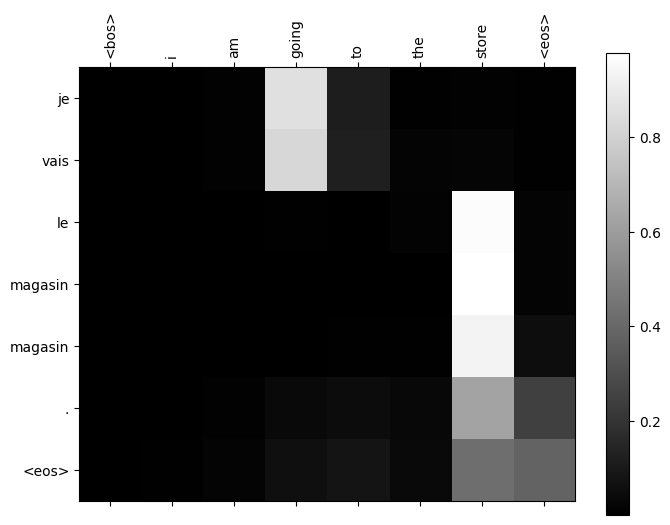

In [62]:
predict_and_show_attention("i am going to the store", seq2seq, device)

Input  >>> how long will you be here ?
Output >>> combien de temps tu tu ici ? <eos>


/tmp/ipykernel_8332/245615704.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_8332/245615704.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


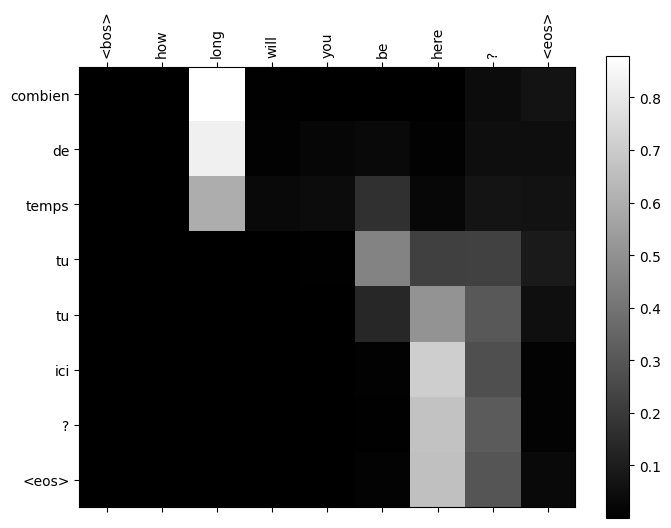

In [63]:
predict_and_show_attention("how long will you be here ?", seq2seq, device)

Input  >>> can we please go to the library ?
Output >>> pouvons nous aller aller rendre la bibliotheque ? <eos>


/tmp/ipykernel_8332/245615704.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_8332/245615704.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


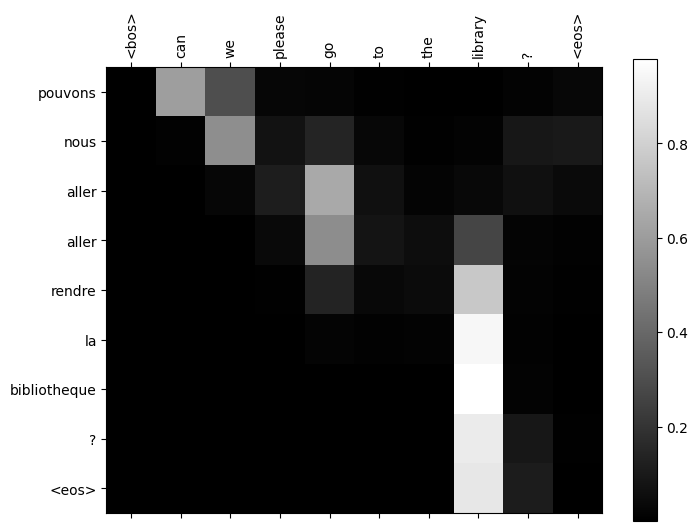

In [64]:
predict_and_show_attention("can we please go to the library ?", seq2seq, device)

Input  >>> her family moved away last year .
Output >>> sa famille est l annee derniere . <eos>


/tmp/ipykernel_8332/245615704.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_8332/245615704.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


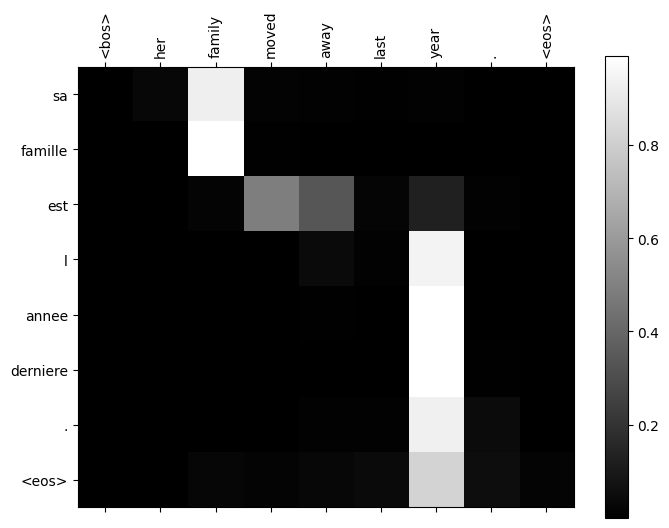

In [65]:
if not FILTER_TO_BASIC_PREFIXES:
  predict_and_show_attention("her family moved away last year .", seq2seq, device)

Input  >>> two thousand people fit into this hall .
Output >>> deux mille personnes ont dans cette cette . . <eos>


/tmp/ipykernel_8332/245615704.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_8332/245615704.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


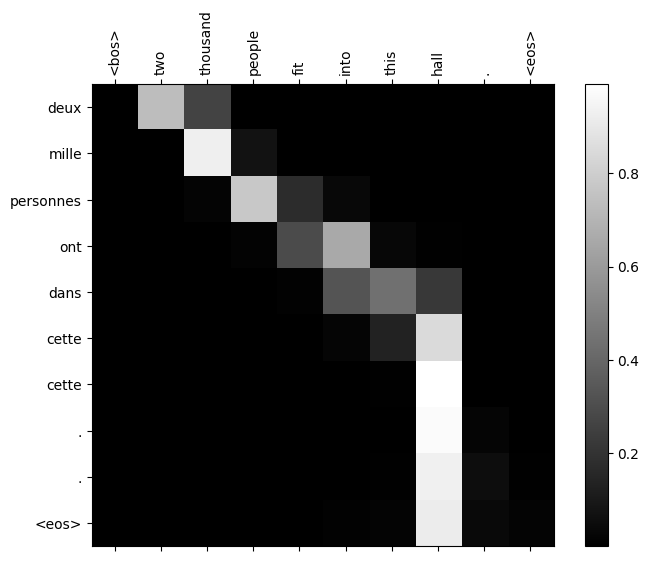

In [66]:
if not FILTER_TO_BASIC_PREFIXES:
  predict_and_show_attention("two thousand people fit into this hall .", seq2seq, device)

Input  >>> the poor young man finally became a great artist .
Output >>> le pauvre jeune homme devint une grande artiste . <eos>


/tmp/ipykernel_8332/245615704.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(src, rotation=90)
/tmp/ipykernel_8332/245615704.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tgt)


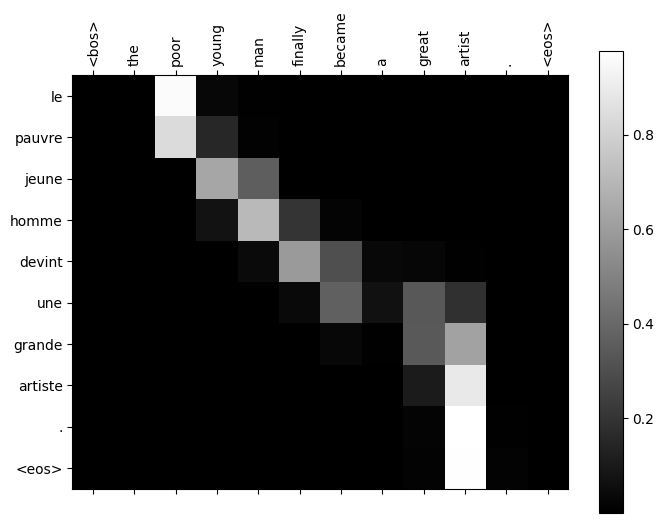

In [67]:
if not FILTER_TO_BASIC_PREFIXES:
  predict_and_show_attention("the poor young man finally became a great artist .", seq2seq, device)

In [58]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")


# Run Date: Tuesday, June 27, 2023
# Run Time: 00:00:28
